In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **1. import & read_csv**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product
from sklearn.preprocessing import LabelEncoder

import calendar
import os
from datetime import datetime

import lightgbm as lgb

%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 100)
os.chdir('/kaggle/input/')

In [8]:
test = pd.read_csv('competitive-data-science-predict-future-sales/test.csv')
sales = pd.read_csv('competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('competitive-data-science-predict-future-sales/shops.csv')
items = pd.read_csv('competitive-data-science-predict-future-sales/items.csv')
item_cats = pd.read_csv('competitive-data-science-predict-future-sales/item_categories.csv')

# **2. sales analysis**

In [9]:
sales.describe().astype('int32')

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849,2935849,2935849,2935849,2935849
mean,14,33,10197,890,1
std,9,16,6324,1729,2
min,0,0,0,-1,-22
25%,7,22,4476,249,1
50%,14,31,9343,399,1
75%,23,47,15684,999,1
max,33,59,22169,307980,2169


<AxesSubplot:xlabel='item_price'>

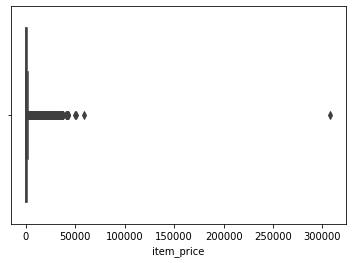

In [10]:
sns.boxplot(x=sales[sales.item_price < 1000000].item_price)

In [15]:
pd.merge(sales[sales.item_price>40000], items, how='left', on='item_id')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,17.09.2013,8,12,11365,59200.0,1.0,Доставка (EMS),9
1,24.10.2013,9,12,7238,42000.0,1.0,UserGate Proxy & Firewall 6.X до 100 сессий,75
2,13.12.2013,11,12,6066,307980.0,1.0,Radmin 3 - 522 лиц.,75
3,20.03.2014,14,25,13199,50999.0,1.0,Коллекционные шахматы (Властелин Колец),69
4,20.11.2014,22,12,14173,40900.0,1.0,Лицензия 1С-Битрикс: Управление сайтом - Эксперт,75
5,29.01.2015,24,12,7241,49782.0,1.0,UserGate Proxy & Firewall 6.X с модулем фильтр...,75
6,23.10.2015,33,42,13403,42990.0,1.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16
7,20.10.2015,33,38,13403,41990.0,1.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16
8,20.10.2015,33,12,13403,41990.0,1.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16
9,29.10.2015,33,12,13403,42990.0,1.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16


<AxesSubplot:xlabel='item_cnt_day'>

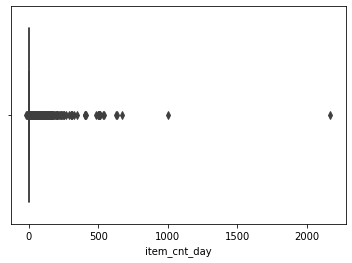

In [17]:
sns.boxplot(x=sales.item_cnt_day)

In [18]:
pd.merge(sales[sales.item_cnt_day>500], items, how='left', on='item_id')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,22.04.2014,15,27,8057,1200.000000,502.0,iTunes 1500 руб.,32
1,28.06.2014,17,25,20949,5.000000,501.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71
2,02.10.2014,21,12,9242,1500.000000,512.0,"Билет ""ИгроМир 2014"" (на один день (отдельно -...",8
3,09.10.2014,21,55,19437,899.000000,508.0,"Средиземье: Тени Мордора [PC, Цифровая версия]",31
4,15.01.2015,24,12,20949,4.000000,1000.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71
5,14.04.2015,27,12,3731,1904.548077,624.0,"Grand Theft Auto V [PC, русские субтитры]",30
6,19.05.2015,28,12,11373,155.192950,539.0,Доставка до пункта выдачи (Boxberry),9
7,29.09.2015,32,55,9249,1500.000000,533.0,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8
8,30.09.2015,32,55,9249,1702.825746,637.0,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8
9,30.09.2015,32,12,9248,1692.526158,669.0,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",80


In [19]:
sales = sales[(sales.item_price < 40000) & (sales.item_price > 0) & (sales.item_cnt_day < 1000)]

In [20]:
shops['city'] = shops.shop_name.apply(lambda x: x.split()[0])
shops.loc[shops['city']=='!Якутск', 'city'] = 'Якутск'

shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

shops.city.unique()

array(['Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Ярославль'], dtype=object)

In [21]:
city_regions = {
                'Адыгея': 'ЦЕНТР',
                'Балашиха': 'МО',
                'Волжский': 'ЦЕНТР',
                'Вологда': 'ЦЕНТР',
                'Воронеж': 'ЦЕНТР',
                'Выездная': 'Интернет',
                'Жуковский': 'МО',
                'Интернет-магазин': 'Интернет',
                'Казань': 'ЦЕНТР',
                'Калуга': 'ЦЕНТР',
                'Коломна': 'МО',
                'Красноярск': 'Сибирь',
                'Курск': 'ЦЕНТР',
                'Москва': 'Москва',
                'Мытищи': 'МО',
                'Н.Новгород': 'ЦЕНТР',
                'Новосибирск': 'Сибирь',
                'Омск': 'Сибирь',
                'РостовНаДону': 'ЦЕНТР',
                'СПб': 'СПб',
                'Самара': 'ЦЕНТР',
                'Сергиев': 'МО',
                'Сургут': 'Сибирь',
                'Томск': 'Сибирь',
                'Тюмень': 'Сибирь',
                'Уфа': 'ЦЕНТР',
                'Химки': 'МО',
                'Цифровой': 'Интернет',
                'Чехов': 'МО',
                'Якутск': 'Сибирь',
                'Ярославль': 'ЦЕНТР'
                }

In [22]:
shops['region'] = shops.city.apply(lambda x: city_regions[x])
shops['region_code'] = LabelEncoder().fit_transform(shops['region'])

shops

,shop_name,shop_id,city,city_code,region,region_code
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29,Сибирь,4
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29,Сибирь,4
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0,ЦЕНТР,5
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1,МО,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2,ЦЕНТР,5
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,3,ЦЕНТР,5
6,"Воронеж (Плехановская, 13)",6,Воронеж,4,ЦЕНТР,5
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,4,ЦЕНТР,5
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,4,ЦЕНТР,5
9,Выездная Торговля,9,Выездная,5,Интернет,0


In [24]:
'''
одинаковое название у магазинов
0=57  1=58   11=10   40=39
Видно, что номера глючные.
'''

pd.pivot_table(sales[sales.shop_id.isin([0, 57, 1, 58, 11, 10, 40, 39])],
    values='item_cnt_day',
    columns='date_block_num',
    index='shop_id',
    aggfunc= 'sum',
    sort=True,
)

date_block_num,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
shop_id,,,,,,,,,,,,,,,,,,,,,
0,5578.0,6127.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2947.0,3364.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,935.0,1026.0,1017.0,756.0,683.0,764.0,800.0,755.0,1027.0,1013.0,...,628.0,NaN,565.0,594.0,466.0,441.0,449.0,442.0,519.0,428.0
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,572.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,888.0,773.0,873.0,754.0,840.0,642.0,638.0,910.0,907.0,997.0
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,443.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,NaN,NaN,6586.0,5493.0,5233.0,5987.0,5827.0,5413.0,5213.0,5686.0,...,4143.0,3540.0,3113.0,2860.0,2408.0,2440.0,2352.0,2780.0,2266.0,2316.0
58,NaN,NaN,3773.0,2831.0,2308.0,2972.0,3122.0,2863.0,2735.0,3022.0,...,2519.0,2360.0,2359.0,1710.0,1378.0,1554.0,1689.0,1738.0,1319.0,1446.0


In [25]:
sales.loc[sales.shop_id == 0, 'shop_id'] = 57
sales.loc[sales.shop_id == 1, 'shop_id'] = 58
sales.loc[sales.shop_id == 11, 'shop_id'] = 10
sales.loc[sales.shop_id == 40, 'shop_id'] = 39

In [26]:
# в тесте неправильных магазинов нет
ar = test.shop_id.unique()
ar.sort()
ar

array([ 2,  3,  4,  5,  6,  7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25,
       26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49,
       50, 52, 53, 55, 56, 57, 58, 59])

# **3  features preparing**

In [27]:
train_columns = ['date_block_num', 'shop_id', 'item_id']

df = []
for dbn in range(0, 34):
    mon_shops = sales[sales.date_block_num == dbn].shop_id.unique()
    mon_items = sales[sales.date_block_num == dbn].item_id.unique()
    df.append(np.array(list(product(*[[dbn], mon_shops, mon_items])), dtype='int16'))

train = pd.DataFrame(np.vstack(df), columns=train_columns, dtype='int16')

train_gr = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum'})
train_gr.columns = ['item_shop_cnt']
train_gr.reset_index(inplace=True)

In [28]:
train = pd.merge(train, train_gr, how='left', on=['date_block_num', 'shop_id', 'item_id'])

In [29]:
sales['item_tot'] = np.abs(sales['item_cnt_day']) * sales['item_price']

train_gr = (sales[sales.item_cnt_day > 0]
                .groupby(by=['date_block_num','shop_id','item_id'])
                .agg({'item_tot': 'sum', 'item_cnt_day': 'sum'})
                .reset_index()
           )
train_gr['item_shop_price'] = train_gr['item_tot'] / train_gr['item_cnt_day']

train = pd.merge(
            train, train_gr[['date_block_num','shop_id','item_id', 'item_shop_price']],
            how='left',
            on=['date_block_num','shop_id','item_id']
            )


train_gr = (sales[sales.item_cnt_day > 0]
                .groupby(by=['date_block_num', 'item_id'])
                .agg({'item_tot': 'sum', 'item_cnt_day': 'sum'})
                .reset_index()
           )
train_gr['item_price_mean'] = train_gr['item_tot'] / train_gr['item_cnt_day']

train = pd.merge(
            train, train_gr[['date_block_num','item_id', 'item_price_mean']],
            how='left',
            on=['date_block_num','item_id']
            )

In [30]:
test['date_block_num'] = 34

train = pd.concat(
            [train, test],
            ignore_index=True, sort=False, 
            keys=['shop_id', 'item_id', 'date_block_num'])

In [31]:
item_cats

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [32]:
l_cat = list(item_cats.item_category_name)

for ind in range(0,1):
    l_cat[ind] = 'Наушники'

for ind in range(1,8):
    l_cat[ind] = 'Аксессуары - приставки'
    
l_cat[8] = 'Билеты (Цифра)'
l_cat[9] = 'Доставка товара'

for ind in range(10,18):
    l_cat[ind] = 'Игровые консоли'

for ind in range(18,25):
    l_cat[ind] = 'Игры консоли'

l_cat[25] = 'Игры - Аксессуары'

for ind in range(26,32):
    l_cat[ind] = 'Игры'

for ind in range(32,37):
    l_cat[ind] = 'Карты оплаты'

for ind in range(37,42):
    l_cat[ind] = 'Кино '

for ind in range(42,55):
    l_cat[ind] = 'Книги'

for ind in range(55,61):
    l_cat[ind] = 'Музыка'

for ind in range(61,73):
    l_cat[ind] = 'Подарки'

for ind in range(73,79):
    l_cat[ind] = 'Программы'

for ind in range(79,81):
    l_cat[ind] = 'Служебные'

for ind in range(81,83):
    l_cat[ind] = 'Чистые носители'

l_cat[83] = 'Элементы питания'



from sklearn import preprocessing

lb = preprocessing.LabelEncoder()

item_cats['item_cat_group_name'] = l_cat
item_cats['item_cat_group'] = lb.fit_transform(l_cat)

In [33]:
items['cat_group'] = items.item_category_id.map(item_cats.set_index('item_category_id')['item_cat_group'])

In [34]:
train['cat_id'] = train.item_id.map(items.set_index('item_id')['item_category_id']).astype('int8')
train['cat_gr'] = train.item_id.map(items.set_index('item_id')['cat_group']).astype('int8')
train['city_code'] = train.shop_id.map(shops.set_index('shop_id')['city_code']).astype('int8')
train['region_code'] = train.shop_id.map(shops.set_index('shop_id')['region_code']).astype('int8')
train['item_shop_rev'] = train['item_shop_price'] * train['item_shop_cnt']

In [35]:
#дней в месяце всего и уикэндов
def month_days(month_number):
    year = 2013 + month_number // 12
    month = 1 + month_number % 12
    weekends = (len([1 for i in calendar.monthcalendar(year, month) if i[5] != 0]) +
                len([1 for i in calendar.monthcalendar(year, month) if i[6] != 0]))
    m_days = calendar.monthrange(year, month)[1]
    return m_days, weekends

month_dict = {i: month_days(i) for i in range(0, 35)}

train['days'] = train.date_block_num.apply(lambda x: month_dict[x][0]).astype('int8')
train['weekends'] = train.date_block_num.apply(lambda x: month_dict[x][1]).astype('int8')

In [36]:
first_item_sale = train.groupby(by='item_id').agg({'date_block_num': 'min'})
first_item_sale.columns = ['first_item_sale']
first_item_sale.reset_index(inplace=True)

first_shop_item_sale = train.groupby(by=['item_id', 'shop_id']).agg({'date_block_num': 'min'})
first_shop_item_sale.columns = ['first_shop_item_sale']
first_shop_item_sale.reset_index(inplace=True)

In [37]:
train = pd.merge(train, first_item_sale, how='left', on='item_id')
train = pd.merge(train, first_shop_item_sale, how='left', on=['item_id', 'shop_id'])

In [38]:
#1й и 2й месяц = new
train['new_item'] = 0
train['new_item_shop'] = 0
train.loc[train.date_block_num == train.first_item_sale, 'new_item'] = 1
train.loc[train.date_block_num == train.first_item_sale + 1, 'new_item'] = 1

train.loc[train.date_block_num == train.first_shop_item_sale, 'new_item_shop'] = 1
train.loc[train.date_block_num == train.first_shop_item_sale + 1, 'new_item_shop'] = 1

#sold before?
train['item_sold_before'] = 0
train['item_shop_sold_before'] = 0
train.loc[train.date_block_num > train.first_item_sale, 'item_sold_before'] = 1
train.loc[train.date_block_num > train.first_shop_item_sale, 'item_shop_sold_before'] = 1

In [39]:
train.drop(columns=['first_item_sale', 'first_shop_item_sale'], inplace=True)

In [40]:
train.fillna(0, inplace=True)

In [41]:
train['date_block_num']  = train['date_block_num'].astype(np.int8)
train['shop_id']         = train['shop_id'].astype(np.int8)
train['item_id']         = train['item_id'].astype(np.int16)
train['item_shop_cnt']   = train['item_shop_cnt'].astype(np.int16)
train['ID']              = train['ID'].astype(np.int32)

train['new_item']  = train['new_item'].astype(np.int8)
train['new_item_shop']  = train['new_item_shop'].astype(np.int8)
train['item_sold_before']  = train['item_sold_before'].astype(np.int8)
train['item_shop_sold_before']  = train['item_shop_sold_before'].astype(np.int8)

train['item_shop_price'] = train['item_shop_price'].astype(np.float32)
train['item_price_mean'] = train['item_price_mean'].astype(np.float32)
train['item_shop_rev'] = train['item_shop_rev'].astype(np.float32)

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11056086 entries, 0 to 11056085
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   date_block_num         int8   
 1   shop_id                int8   
 2   item_id                int16  
 3   item_shop_cnt          int16  
 4   item_shop_price        float32
 5   item_price_mean        float32
 6   ID                     int32  
 7   cat_id                 int8   
 8   cat_gr                 int8   
 9   city_code              int8   
 10  region_code            int8   
 11  item_shop_rev          float32
 12  days                   int8   
 13  weekends               int8   
 14  new_item               int8   
 15  new_item_shop          int8   
 16  item_sold_before       int8   
 17  item_shop_sold_before  int8   
dtypes: float32(3), int16(2), int32(1), int8(12)
memory usage: 421.8 MB


In [43]:
train.to_pickle('/kaggle/working/train.pkl')

In [ ]:
train = pd.read_pickle('/kaggle/working/train.pkl')

In [44]:
# clip (25 better 20)
train['item_shop_cnt'] = (train['item_shop_cnt']
                                .fillna(0)
                                .clip(0, 25) 
                                .astype(np.int16))

In [45]:
def feat_lags(df, lags, lag_columns):
    df_shift = df[['date_block_num', 'shop_id', 'item_id', *lag_columns]].copy()
    j = 0
    columns_dict = {}
    for col in lag_columns:
        columns_dict[col] = (col + '_lag-1')
    for i in range(1, len(lags)):
        for col in lag_columns:
            columns_dict[col + '_lag-' + str(lags[i-1])] = (col + '_lag-' + str(lags[i]))
    # print(columns_dict)

    for i in lags:
        df_shift['date_block_num'] += i - j
        j = i
        df_shift.rename(columns=columns_dict, inplace=True)
        df = df.merge(df_shift, how='left', on=['date_block_num', 'shop_id', 'item_id'])
        print(i, df.shape, df_shift.shape)

    return df

In [46]:
feat_list = ['item_shop_cnt', 'item_shop_price', 'item_price_mean']

In [47]:
train_gr = train.groupby(by=['date_block_num', 'shop_id']).agg({'item_shop_rev': 'sum'})
train_gr.columns = ['shop_rev']
train_gr.reset_index()

train = pd.merge(train, train_gr, how='left', on=['date_block_num', 'shop_id'])

feat_list.append('shop_rev')

In [48]:
train_gr = train.groupby(by=['date_block_num', 'item_id']).agg({'item_shop_cnt': 'mean'})
train_gr.columns = ['item_cnt_mean']
train_gr.reset_index()

train = pd.merge(train, train_gr, how='left', on=['date_block_num', 'item_id'])

feat_list.append('item_cnt_mean')

In [49]:
train_gr = train.groupby(by=['date_block_num', 'cat_id']).agg({'item_shop_cnt': 'mean'})
train_gr.columns = ['cat_cnt_mean']
train_gr.reset_index()

train = pd.merge(train, train_gr, how='left', on=['date_block_num', 'cat_id'])

feat_list.append('cat_cnt_mean')

In [50]:
train_gr = (train.groupby(by=['date_block_num', 'cat_id', 'shop_id'])
                 .agg({'item_shop_cnt': 'mean'})
                 .rename(columns={'item_shop_cnt': 'cat_shop_cnt_mean'})
                 .reset_index()
           )

train = pd.merge(train, train_gr, how='left', on=['date_block_num', 'cat_id', 'shop_id'])

feat_list.append('cat_shop_cnt_mean')

In [51]:
lags_list = [1, 2, 3]
train = feat_lags(train, lags_list, feat_list)

1 (11056086, 29) (11056086, 10)
2 (11056086, 36) (11056086, 10)
3 (11056086, 43) (11056086, 10)


In [52]:
#Добавляем данные по похожим товарам - 1 к айди

def similar_item_lags(df, lags, id_column):
    df_shift = df[['date_block_num', 'shop_id', 'item_id', id_column]].copy()
    df_shift['item_id'] = df_shift['item_id'] - 1
    j = 0
    columns_dict = {}
    columns_dict[id_column] = ('sim_id_cnt_lag-1')
    
    for i in range(1, len(lags)):
        columns_dict['sim_id_cnt_lag-' + str(lags[i-1])] = ('sim_id_cnt_lag-' + str(lags[i]))

    for i in lags:
        df_shift['date_block_num'] += i - j
        j = i
        df_shift.rename(columns=columns_dict, inplace=True)
        df = df.merge(df_shift, how='left', on=['date_block_num', 'shop_id', 'item_id'])
        print(i, df.shape, df_shift.shape)

    return df

In [53]:
lags_list = [1, 2, 3]

train = similar_item_lags(train, lags_list, 'item_shop_cnt')

1 (11056086, 44) (11056086, 4)
2 (11056086, 45) (11056086, 4)
3 (11056086, 46) (11056086, 4)


In [54]:
train = train[(train['date_block_num'] > 2)]

train.drop(columns=[
    'item_cnt_mean',
    'item_shop_price',
    'item_price_mean',
    'item_shop_rev',
    'shop_rev',
    'cat_cnt_mean',
    'cat_shop_cnt_mean'], inplace=True)

train.fillna(0, inplace=True)

In [55]:
train['item_shop_cnt_lag-1adv']        = ((train['item_shop_cnt_lag-1'] + 
                                           train['item_shop_cnt_lag-2']) / 2).astype(np.float32)


train['item_shop_cnt_lag-1']        = train['item_shop_cnt_lag-1'].astype(np.float32)
train['item_shop_price_lag-1']      = train['item_shop_price_lag-1'].astype(np.float32)
train['item_cnt_mean_lag-1']        = train['item_cnt_mean_lag-1'].astype(np.float32)
train['item_price_mean_lag-1']      = train['item_price_mean_lag-1'].astype(np.float32)
train['cat_cnt_mean_lag-1']         = train['cat_cnt_mean_lag-1'].astype(np.float32)
train['cat_shop_cnt_mean_lag-1']    = train['cat_shop_cnt_mean_lag-1'].astype(np.float32)
train['shop_rev_lag-1']             = train['shop_rev_lag-1'].astype(np.float32)

train['item_shop_cnt_lag-2']        = train['item_shop_cnt_lag-2'].astype(np.float32)
train['item_shop_price_lag-2']      = train['item_shop_price_lag-2'].astype(np.float32)
train['item_cnt_mean_lag-2']        = train['item_cnt_mean_lag-2'].astype(np.float32)
train['item_price_mean_lag-2']      = train['item_price_mean_lag-2'].astype(np.float32)
train['cat_cnt_mean_lag-2']         = train['cat_cnt_mean_lag-2'].astype(np.float32)
train['cat_shop_cnt_mean_lag-2']    = train['cat_shop_cnt_mean_lag-2'].astype(np.float32)
train['shop_rev_lag-2']             = train['shop_rev_lag-2'].astype(np.float32)

train['item_shop_cnt_lag-3']        = train['item_shop_cnt_lag-3'].astype(np.float32)
train['item_shop_price_lag-3']      = train['item_shop_price_lag-3'].astype(np.float32)
train['item_cnt_mean_lag-3']        = train['item_cnt_mean_lag-3'].astype(np.float32)
train['item_price_mean_lag-3']      = train['item_price_mean_lag-3'].astype(np.float32)
train['cat_cnt_mean_lag-3']         = train['cat_cnt_mean_lag-3'].astype(np.float32)
train['cat_shop_cnt_mean_lag-3']    = train['cat_shop_cnt_mean_lag-3'].astype(np.float32)
train['shop_rev_lag-3']             = train['shop_rev_lag-3'].astype(np.float32)


train['sim_id_cnt_lag-1']        = train['sim_id_cnt_lag-1'].astype(np.float32)
train['sim_id_cnt_lag-2']        = train['sim_id_cnt_lag-2'].astype(np.float32)
train['sim_id_cnt_lag-3']        = train['sim_id_cnt_lag-3'].astype(np.float32)

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9933291 entries, 1122795 to 11056085
Data columns (total 40 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   date_block_num           int8   
 1   shop_id                  int8   
 2   item_id                  int16  
 3   item_shop_cnt            int16  
 4   ID                       int32  
 5   cat_id                   int8   
 6   cat_gr                   int8   
 7   city_code                int8   
 8   region_code              int8   
 9   days                     int8   
 10  weekends                 int8   
 11  new_item                 int8   
 12  new_item_shop            int8   
 13  item_sold_before         int8   
 14  item_shop_sold_before    int8   
 15  item_shop_cnt_lag-1      float32
 16  item_shop_price_lag-1    float32
 17  item_price_mean_lag-1    float32
 18  shop_rev_lag-1           float32
 19  item_cnt_mean_lag-1      float32
 20  cat_cnt_mean_lag-1       float32
 21  c

In [59]:
train.to_pickle('/kaggle/working/dataset_clip25.pkl')

In [60]:
dataset = pd.read_pickle('/kaggle/working/dataset_clip25.pkl')


In [61]:
dataset['item_shop_cnt_var']     = (dataset['item_shop_cnt_lag-1']  / 
                                        dataset['item_shop_cnt_lag-2'] - 1).fillna(0).astype(np.float16)
dataset['item_shop_price_var']   = (dataset['item_shop_price_lag-1']  / 
                                        dataset['item_shop_price_lag-2'] - 1).fillna(0).astype(np.float16)
dataset['item_cnt_mean_var']     = (dataset['item_cnt_mean_lag-1']  / 
                                        dataset['item_cnt_mean_lag-2'] - 1).fillna(0).astype(np.float16)
dataset['item_price_mean_var']   = (dataset['item_price_mean_lag-1']  / 
                                        dataset['item_price_mean_lag-2'] - 1).fillna(0).astype(np.float16)
dataset['cat_cnt_mean_var']      = (dataset['cat_cnt_mean_lag-1']  / 
                                        dataset['cat_cnt_mean_lag-2'] - 1).fillna(0).astype(np.float16)
dataset['cat_shop_cnt_mean_var'] = (dataset['cat_shop_cnt_mean_lag-1']  / 
                                         dataset['cat_shop_cnt_mean_lag-2'] - 1).fillna(0).astype(np.float16)
dataset['shop_rev_var']          = (dataset['shop_rev_lag-1']  / 
                                        dataset['shop_rev_lag-2'] - 1).fillna(0).astype(np.float16)

dataset['sim_id_var']          = (dataset['sim_id_cnt_lag-1']  / 
                                        dataset['sim_id_cnt_lag-2'] - 1).fillna(0).astype(np.float16)

dataset['month'] = (dataset['date_block_num'] % 12) + 1

# **Model**

In [62]:
X_train = dataset[dataset.date_block_num <  33].drop(columns=['ID', 'item_shop_cnt'])
Y_train = dataset[dataset.date_block_num <  33]['item_shop_cnt']
X_valid = dataset[dataset.date_block_num == 33].drop(columns=['ID', 'item_shop_cnt'])
Y_valid = dataset[dataset.date_block_num == 33]['item_shop_cnt']
X_test  = dataset[dataset.date_block_num == 34].drop(columns=['ID', 'item_shop_cnt'])
id_test = dataset[dataset.date_block_num == 34]['ID']

In [63]:
feature_list = X_train.columns.tolist()

In [64]:
params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 7 - 1,
    'learning_rate': 0.01,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}

categorical_list = [    'cat_id', 
                        'cat_gr',
                        'region_code',
                        'city_code',
                        'new_item',
                        'new_item_shop',
                        'item_sold_before',
                        'item_shop_sold_before']

lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval  = lgb.Dataset(X_valid, Y_valid, reference=lgb_train)

evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train,
        num_boost_round=3000,
        valid_sets=(lgb_train, lgb_eval), 
        feature_name = feature_list,
        categorical_feature = categorical_list,
        verbose_eval=5, 
        evals_result = evals_result,
        early_stopping_rounds = 100)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cat_gr', 'cat_id', 'city_code', 'item_shop_sold_before', 'item_sold_before', 'new_item', 'new_item_shop', 'region_code']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be re

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 4.403525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7105
[LightGBM] [Info] Number of data points in the train set: 9480919, number of used features: 47


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 0.300784
Training until validation scores don't improve for 100 rounds
[5]	training's rmse: 1.26762	valid_1's rmse: 1.19922
[10]	training's rmse: 1.24201	valid_1's rmse: 1.18024
[15]	training's rmse: 1.21836	valid_1's rmse: 1.1626
[20]	training's rmse: 1.19542	valid_1's rmse: 1.14629
[25]	training's rmse: 1.17444	valid_1's rmse: 1.13119
[30]	training's rmse: 1.15595	valid_1's rmse: 1.11816
[35]	training's rmse: 1.13785	valid_1's rmse: 1.10621
[40]	training's rmse: 1.12119	valid_1's rmse: 1.0953
[45]	training's rmse: 1.10535	valid_1's rmse: 1.08462
[50]	training's rmse: 1.09035	valid_1's rmse: 1.07469
[55]	training's rmse: 1.07681	valid_1's rmse: 1.06573
[60]	training's rmse: 1.06422	valid_1's rmse: 1.05797
[65]	training's rmse: 1.05262	valid_1's rmse: 1.05029
[70]	training's rmse: 1.04189	valid_1's rmse: 1.0439
[75]	training's rmse: 1.03177	valid_1's rmse: 1.03758
[80]	training's rmse: 1.02201	valid_1's rmse: 1.03252
[85]	training's rmse: 1.0

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

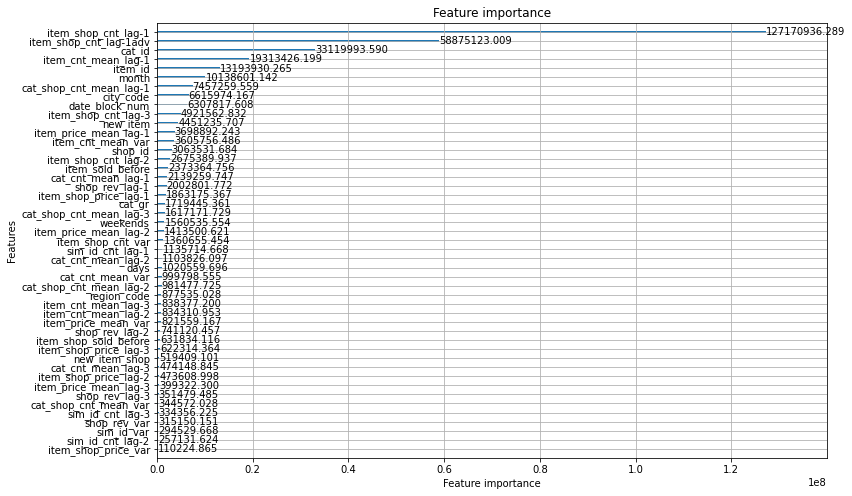

In [65]:
lgb.plot_importance(
    gbm, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12, 8))

In [66]:
Y_test = gbm.predict(X_test[feature_list]).clip(0, 20)

In [ ]:
submission = pd.DataFrame({
    "ID": id_test,
    "item_cnt_month": Y_test
})

submission.to_csv('/kaggle/working/gbm_subm_simid_rmse_25_999_999.csv', index=False)